##Задание.

Рассчитайте наценку на ювелирные изделия по данным на листе ""Задание 2"". Соблюсти следующие условия:
1. Период анализа - с 1.04.23 по 10.04.23
2. В анализе должны участвовать только продажи изделий с общей суммой и себестоимостью больше 0 рублей
3. В ответе необходимо получить два значения наценки - среднюю наценку на ювелирные изделия из золота и среднюю наценку на ювелирные изделия из серебра. Сгруппировать изделия по металлу нужно на основе поля ""Товарная группа"". Товарная группа изделий из серебра начинается на ""СИ"", все остальные изделия - это золото.

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

Подгрузим данные с гугл диска и подгрузим нужный нам лист в датафрэйм.

In [122]:
url = 'https://docs.google.com/spreadsheets/d/1RPmcAaW64wNqGdxY5wqvmmOGZ_y16kqY/edit?usp=drive_link&ouid=100738510060926451894&rtpof=true&sd=true'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

In [123]:
sales = pd.read_excel(path, sheet_name=2)

#### EDA
Посмотрим на данные.

In [147]:
sales.head()

,date,check_number,name,id,product_group,CH_characteristic,weight,sum,cost_price
0,2023-04-01 10:05:39,1814,серьги с брил.+изумрудом с родир,1078601904686,ДК СЕРЬГИ,Au 585º -,2.89,51180.0,17276.0475
1,2023-04-01 10:08:03,4868,Серьги с топазом,1078551306013,ПДК СЕРЬГИ,Au 585º -,3.99,34740.0,12074.7470
2,2023-04-01 10:08:23,617,Кольцо с брилл.+изум.гидротерм. с родир.,1078509166518,ДК КОЛЬЦА,"Au 585º -, разм.18,5",2.05,17760.0,6629.6120
3,2023-04-01 10:11:38,461,Кольцо с амет. род.,1078579406088,СИ КОЛЬЦО ЦВ/К,"Ag 925º -, разм.19,0",1.46,756.0,302.2200
4,2023-04-01 10:12:00,3939,Цепь Якорь с а/г род.,1078601866814,СИ ЦЕПЬ,"Ag 925º -, разм.40,0",2.70,1560.0,458.9995


In [148]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139997 entries, 0 to 139996
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               139997 non-null  datetime64[ns]
 1   check_number       139997 non-null  int64         
 2   name               139997 non-null  object        
 3   id                 139997 non-null  int64         
 4   product_group      139997 non-null  object        
 5   CH_characteristic  139996 non-null  object        
 6   weight             139997 non-null  float64       
 7   sum                139997 non-null  float64       
 8   cost_price         139997 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 9.6+ MB


Переименуем колонки для удобства работы.

In [149]:
sales.columns

Index(['date', 'check_number', 'name', 'id', 'product_group',
       'CH_characteristic', 'weight', 'sum', 'cost_price'],
      dtype='object')

In [150]:
sales.columns = ['date', 'check_number', 'name', 'id', 'product_group',
                 'CH_characteristic', 'weight', 'sum', 'cost_price']

Изучим пропуски в данных и посмотрим описательную статистику по данным.

In [151]:
sales.isna().sum()

date                 0
check_number         0
name                 0
id                   0
product_group        0
CH_characteristic    1
weight               0
sum                  0
cost_price           0
dtype: int64

In [152]:
sales[sales['CH_characteristic'].isna()]

,date,check_number,name,id,product_group,CH_characteristic,weight,sum,cost_price
53753,2023-04-05 17:48:13,3409,"Кольцо, фианит",1078560377007,ИФ КОЛЬЦА,NaN,0.97,5700.0,1690.408


In [153]:
sales['CH_characteristic'].value_counts()

Ag 925º -                      32524
Au 585º -                      27940
Au 375º -                       5972
Au 585º -, разм.17,0            4722
Au 585º -, разм.18,0            4648
                               ...  
Au 750º -, разм.15,5               1
Au/Ag 585/925º -, разм.17,5        1
Ag 875º -                          1
Au 585º -, разм.80,0               1
Ag 960º -, разм.18,0               1
Name: CH_characteristic, Length: 131, dtype: int64

In [154]:
sales.describe()

,check_number,id,weight,sum,cost_price
count,139997.000000,1.399970e+05,139997.000000,139997.000000,139997.000000
mean,3316.727916,1.077370e+12,3.089485,8965.226457,3526.145000
std,1991.283099,3.441787e+10,4.914037,12637.702621,5978.040532
min,1.000000,7.810667e+10,-115.060000,-95463.360000,-52384.880500
25%,1546.000000,1.078550e+12,1.160000,1428.000000,485.265500
50%,3551.000000,1.078601e+12,1.900000,5148.000000,1893.969500
75%,4518.000000,1.078602e+12,3.110000,13080.000000,4966.010500
max,11793.000000,1.078902e+12,147.060000,652680.000000,365339.268000


####Срез данных по датам

Отберем для анализа подходящий по заданию период времени.

In [155]:
sales_slice = sales[sales['date'].between("2023-04-01", "2023-04-10")]
sales_slice.head()

,date,check_number,name,id,product_group,CH_characteristic,weight,sum,cost_price
0,2023-04-01 10:05:39,1814,серьги с брил.+изумрудом с родир,1078601904686,ДК СЕРЬГИ,Au 585º -,2.89,51180.0,17276.0475
1,2023-04-01 10:08:03,4868,Серьги с топазом,1078551306013,ПДК СЕРЬГИ,Au 585º -,3.99,34740.0,12074.7470
2,2023-04-01 10:08:23,617,Кольцо с брилл.+изум.гидротерм. с родир.,1078509166518,ДК КОЛЬЦА,"Au 585º -, разм.18,5",2.05,17760.0,6629.6120
3,2023-04-01 10:11:38,461,Кольцо с амет. род.,1078579406088,СИ КОЛЬЦО ЦВ/К,"Ag 925º -, разм.19,0",1.46,756.0,302.2200
4,2023-04-01 10:12:00,3939,Цепь Якорь с а/г род.,1078601866814,СИ ЦЕПЬ,"Ag 925º -, разм.40,0",2.70,1560.0,458.9995


#### Срез данных по сумме и себестоимости

Теперь отберем строки с суммой и себестоимостью больше 0.

In [156]:
sales_slice = (sales_slice[(sales_slice['sum'] > 0)
                & (sales_slice['cost_price'] > 0)])

####Срез данных по товарной группе

Сгруппировать изделия по металлу нужно на основе поля ""Товарная группа"". Товарная группа изделий из серебра начинается на ""СИ"", все остальные изделия - это золото.

Сделаем дополнительную колонку с разделением золотое изделие или серебряное, для упрощения дальнейшей групировки.


In [157]:
sales_slice['product_group']

0              ДК СЕРЬГИ
1             ПДК СЕРЬГИ
2              ДК КОЛЬЦА
3         СИ КОЛЬЦО ЦВ/К
4                СИ ЦЕПЬ
               ...      
126453         ДК СЕРЬГИ
126454         ДК СЕРЬГИ
126455         ИФ КОЛЬЦА
126456         ДК СЕРЬГИ
126457    СИ СЕРЬГИ РАЗН
Name: product_group, Length: 84614, dtype: object

In [158]:
sales_slice['metal'] = (sales_slice['product_group']
                        .apply(lambda x: 'Ag' if 'СИ' in x else 'Au'))

In [159]:
sales_slice.head()

,date,check_number,name,id,product_group,CH_characteristic,weight,sum,cost_price,metal
0,2023-04-01 10:05:39,1814,серьги с брил.+изумрудом с родир,1078601904686,ДК СЕРЬГИ,Au 585º -,2.89,51180.0,17276.0475,Au
1,2023-04-01 10:08:03,4868,Серьги с топазом,1078551306013,ПДК СЕРЬГИ,Au 585º -,3.99,34740.0,12074.7470,Au
2,2023-04-01 10:08:23,617,Кольцо с брилл.+изум.гидротерм. с родир.,1078509166518,ДК КОЛЬЦА,"Au 585º -, разм.18,5",2.05,17760.0,6629.6120,Au
3,2023-04-01 10:11:38,461,Кольцо с амет. род.,1078579406088,СИ КОЛЬЦО ЦВ/К,"Ag 925º -, разм.19,0",1.46,756.0,302.2200,Ag
4,2023-04-01 10:12:00,3939,Цепь Якорь с а/г род.,1078601866814,СИ ЦЕПЬ,"Ag 925º -, разм.40,0",2.70,1560.0,458.9995,Ag


Дополнительно нужно создать колонку с наценкой.

In [161]:
sales_slice['margin'] = sales_slice.loc[:, 'sum'] - sales_slice.loc[:, 'cost_price']
sales_slice.head()

,date,check_number,name,id,product_group,CH_characteristic,weight,sum,cost_price,metal,margin
0,2023-04-01 10:05:39,1814,серьги с брил.+изумрудом с родир,1078601904686,ДК СЕРЬГИ,Au 585º -,2.89,51180.0,17276.0475,Au,33903.9525
1,2023-04-01 10:08:03,4868,Серьги с топазом,1078551306013,ПДК СЕРЬГИ,Au 585º -,3.99,34740.0,12074.7470,Au,22665.2530
2,2023-04-01 10:08:23,617,Кольцо с брилл.+изум.гидротерм. с родир.,1078509166518,ДК КОЛЬЦА,"Au 585º -, разм.18,5",2.05,17760.0,6629.6120,Au,11130.3880
3,2023-04-01 10:11:38,461,Кольцо с амет. род.,1078579406088,СИ КОЛЬЦО ЦВ/К,"Ag 925º -, разм.19,0",1.46,756.0,302.2200,Ag,453.7800
4,2023-04-01 10:12:00,3939,Цепь Якорь с а/г род.,1078601866814,СИ ЦЕПЬ,"Ag 925º -, разм.40,0",2.70,1560.0,458.9995,Ag,1101.0005


#### Результаты
Сгрупируем данные по колонке в которой указано серебряное или золотое изделие и посчитаем количество проданых изделий и среднюю наценку.

In [162]:
mean_margin = sales_slice.groupby('metal').agg(quantity=('id', 'count'),
                                 mean_margin=('margin', 'mean'))
mean_margin

,quantity,mean_margin
metal,,
Ag,36933,1293.690315
Au,47681,8634.467263


In [163]:
print(f"Средняя наценка за изделие из золота: {mean_margin['mean_margin'].iloc[1]}\n"
      f"Средняя наценка за изделие из серебра: {mean_margin['mean_margin'].iloc[0]}")

Средняя наценка за изделие из золота: 8634.46726331244
Средняя наценка за изделие из серебра: 1293.6903152329899


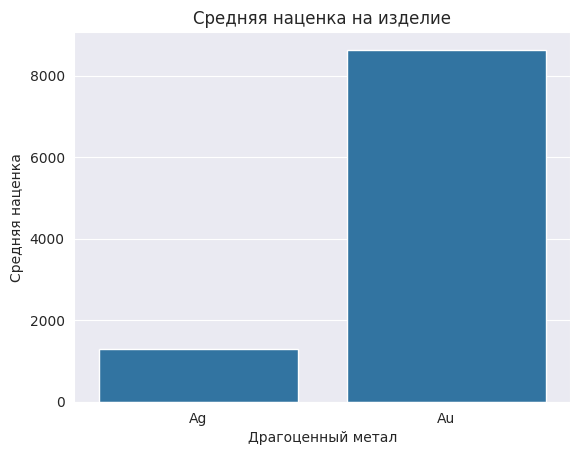

In [164]:
sns.barplot(data=mean_margin.reset_index(), x='metal', y='mean_margin')
plt.title('Средняя наценка на изделие')
plt.xlabel('Драгоценный метал')
plt.ylabel('Средняя наценка')
plt.show()

Средняя наценка на изделия из золота в несколько раз выше наценки за изделия из серебра, так же количество проданых товаров из золота выше, чем из серебра.